In [27]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [31]:
df=pd.read_csv("spam.csv",names=["label","text"])

In [32]:
df.head()

,label,text
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


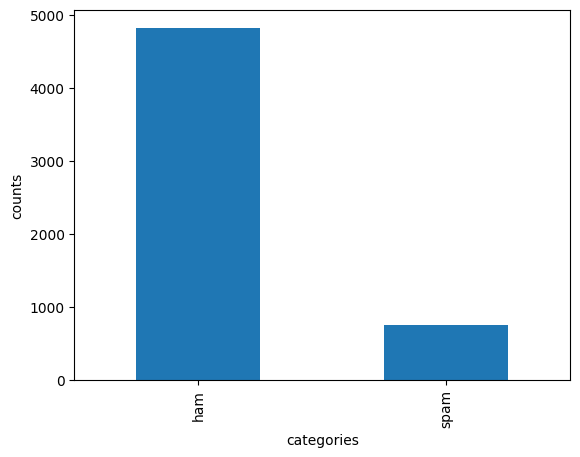

In [33]:
ax=df.label.value_counts().plot(kind="bar")
ax.set_xlabel("categories")
ax.set_ylabel("counts")
plt.show(ax)

In [34]:
df.label.value_counts()

ham     4825
spam     747
Name: label, dtype: int64

In [35]:
df.isna().sum()

label    0
text     0
dtype: int64

In [36]:
df.duplicated().sum()

403

In [37]:
df.drop_duplicates()['label'].value_counts()

ham     4516
spam     653
Name: label, dtype: int64

In [38]:
df.drop_duplicates(inplace=True)

In [39]:
len(df)

5169

In [40]:
from sklearn.preprocessing import LabelEncoder
obj=LabelEncoder()
df['label']=obj.fit_transform(df.label)

In [41]:
df.head()

,label,text
0,0,"Go until jurong point, crazy.. Available only ..."
1,0,Ok lar... Joking wif u oni...
2,1,Free entry in 2 a wkly comp to win FA Cup fina...
3,0,U dun say so early hor... U c already then say...
4,0,"Nah I don't think he goes to usf, he lives aro..."


In [42]:
labels=["ham","spam"]

mappings={id : label for label,id in zip(labels,obj.transform(labels))}

In [43]:
mappings

{0: 'ham', 1: 'spam'}

In [44]:
from sklearn.model_selection import train_test_split
x_train,x_test,y_train,y_test=train_test_split(list(df['text']),list(df['label']),test_size=0.2,stratify=df['label'],random_state=42)


In [45]:
type(x_train)

list

In [2]:
!pip install transformers

In [12]:
from transformers import TFAutoModelForSequenceClassification,AutoTokenizer
model_name="distilbert-base-uncased-finetuned-sst-2-english"
tokenizer=AutoTokenizer.from_pretrained(model_name)

In [13]:
model=TFAutoModelForSequenceClassification.from_pretrained(model_name)

All PyTorch model weights were used when initializing TFDistilBertForSequenceClassification.

All the weights of TFDistilBertForSequenceClassification were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFDistilBertForSequenceClassification for predictions without further training.


**Testing purpose**

In [22]:
test=tokenizer(["cricket is the best game in the world at present","i hate singing"],padding=True,truncation=True,return_tensors="tf")
output = model(**test)
output

In [46]:
train_encodings=tokenizer(x_train,padding=True,truncation=True,return_tensors="tf",max_length=512)
test_encodings=tokenizer(x_test,padding=True,truncation=True,return_tensors="tf",max_length=512)

In [53]:
import tensorflow as tf

train_dataset=tf.data.Dataset.from_tensor_slices((
    train_encodings,
    y_train

))

test_dataset=tf.data.Dataset.from_tensor_slices((
    test_encodings,
    y_test
))

In [54]:
type(train_dataset)

tensorflow.python.data.ops.from_tensor_slices_op._TensorSliceDataset

In [55]:
from transformers import TFTrainer,TFTrainingArguments


In [56]:
training_args = TFTrainingArguments(
    output_dir='./results',          # output directory
    num_train_epochs=2,              # total number of training epochs
    per_device_train_batch_size=8,  # batch size per device during training
    per_device_eval_batch_size=16,   # batch size for evaluation
    warmup_steps=500,                # number of warmup steps for learning rate scheduler
    weight_decay=0.01,               # strength of weight decay
    logging_dir='./logs',            # directory for storing logs
    logging_steps=10,
)

In [25]:
# with training_args.strategy.scope():
#     model = TFDistilBertForSequenceClassification.from_pretrained("distilbert-base-uncased")

# trainer = TFTrainer(
#     model=model,                         # the instantiated 🤗 Transformers model to be trained
#     args=training_args,                  # training arguments, defined above
#     train_dataset=train_dataset,         # training dataset
#     eval_dataset=test_dataset             # evaluation dataset
# )

# trainer.train()


In [63]:
try :
  with training_args.strategy.scope() :
    model=TFAutoModelForSequenceClassification.from_pretrained(model_name)
  trainer=TFTrainer(
        model=model,
        args=training_args,
        train_dataset=train_dataset,
        eval_dataset=test_dataset
    )

  trainer.train()
except TypeError:
  print("typeerror")




All PyTorch model weights were used when initializing TFDistilBertForSequenceClassification.

All the weights of TFDistilBertForSequenceClassification were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFDistilBertForSequenceClassification for predictions without further training.
/usr/local/lib/python3.10/dist-packages/transformers/trainer_tf.py:118: FutureWarning: The class `TFTrainer` is deprecated and will be removed in version 5 of Transformers. We recommend using native Keras instead, by calling methods like `fit()` and `predict()` directly on the model object. Detailed examples of the Keras style can be found in our examples at https://github.com/huggingface/transformers/tree/main/examples/tensorflow
  warnings.warn(


typeerror


In [64]:
trainer.evaluate(test_dataset)

{'eval_loss': 2.3784900371844953}

In [65]:
y_pred=trainer.predict(test_dataset)

In [67]:
y_pred[0]

array([[-3.8897946 ,  4.203346  ],
       [-2.4326112 ,  2.5963945 ],
       [-3.5232525 ,  3.688401  ],
       ...,
       [ 0.64201224, -0.41832054],
       [ 1.6865001 , -1.4595796 ],
       [ 3.7297935 , -3.1353748 ]], dtype=float32)

In [68]:
y_pred[1]

array([0, 0, 0, ..., 1, 0, 0], dtype=int32)

In [69]:
from sklearn.metrics import classification_report

In [71]:
clr=classification_report(y_test,y_pred[1])

In [73]:
print(clr)

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       903
           1       1.00      1.00      1.00       131

    accuracy                           1.00      1034
   macro avg       1.00      1.00      1.00      1034
weighted avg       1.00      1.00      1.00      1034



<Axes: >

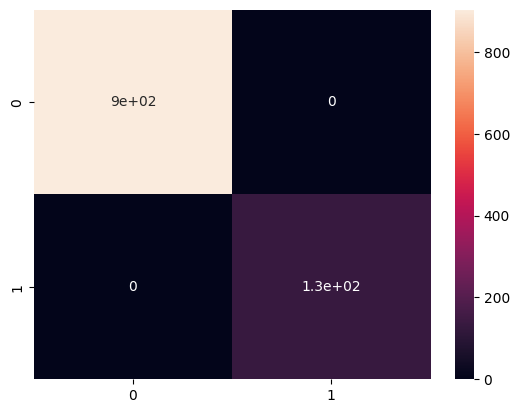

In [76]:
from sklearn.metrics import confusion_matrix
cm=confusion_matrix(y_test,y_pred[1])
import seaborn as sns
sns.heatmap(cm,annot=True)

In [77]:
trainer.save_model("distill bert classification model")